# Cleanup & Preprocess with Ngrams


*Purpose*
- generalize the **DocumentToBigramCounterTransformer** class to a **DocumentToNgramCounterTransformer** class. 


---

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd

import urlextract
from html import unescape

from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import cleanup_module as Cmod

from scipy.sparse import csr_matrix
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer

---

### Load Data

In [2]:
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

url_extractor = urlextract.URLExtract()
lemmatizer = WordNetLemmatizer()

In [3]:
# load X, y train subsets
raw_path = os.path.join("..","data","1_raw")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# create arrays
X_array = np.array(X_train.iloc[:,0]).ravel()
y_array = np.array(y_train.iloc[:,0]).ravel()

### Cleanup $\longrightarrow$ Preprocessing $\longrightarrow$ Baseline Models

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def gridsearch_ngrams(X_array, y_array, n_grams, vocab_sizes):
    """Grid searches for a given n_gram value, varying vocab_sizes 
       Using BoW and Tf-Idf representations
       Naive Bayes and Logistic Regression baseline models 
       Performs 5-fold cross validation
       Returns dataframe with mean accuracies, fit and modeling times
    """
    T1 = time.time()
    
    # instantiate lists
    bow_fit_times, tfidf_fit_times, bow_mod_times, tfidf_mod_times = [], [], [], []
    NB_bow, LR_bow, NB_tfidf, LR_tfidf = [], [], [], []
    
    for vocab_size in vocab_sizes:
        pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer(n_grams=n_grams)),
                         ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=vocab_size)),
                         ('tfidf', TfidfTransformer())])  
        # BoW fit
        bow_fit_start = time.time()
        X_counter = pipe['counter'].fit_transform(X_array)
        X_bow = pipe['bow'].fit_transform(X_counter)
        bow_fit_times.append(round(time.time() - bow_fit_start, 1))
        
        # Tfidf fit
        tfidf_fit_start = time.time()
        X_tfidf = pipe['tfidf'].fit_transform(X_bow)
        tfidf_fit_times.append(round(time.time() - tfidf_fit_start, 1))
        
        # instantiate models
        NB_clf = MultinomialNB()
        log_clf = LogisticRegression(solver="liblinear", random_state=42) 
        
        # BoW modeling
        bow_mod_start = time.time()
        bow_NBscores = cross_val_score(NB_clf, X_bow, y_array, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)
        bow_LRscores = cross_val_score(log_clf, X_bow, y_array, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)     
        NB_bow.append(round(bow_NBscores.mean(), 4))
        LR_bow.append(round(bow_LRscores.mean(), 4))
        bow_mod_times.append(round(time.time() - bow_mod_start, 1))
        
        # Tfidf modeling
        tfidf_mod_start = time.time()
        tfidf_NBscores = cross_val_score(NB_clf, X_tfidf, y_array, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)
        tfidf_LRscores = cross_val_score(log_clf, X_tfidf, y_array, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)     
        NB_tfidf.append(round(tfidf_NBscores.mean(), 4))
        LR_tfidf.append(round(tfidf_LRscores.mean(), 4))
        tfidf_mod_times.append(round(time.time() - tfidf_mod_start, 1))
             
    df = pd.DataFrame({"ngram":n_grams,
                       "vocab_size":vocab_sizes,
                       "bow_fit_time":bow_fit_times,
                       "tfidf_fit_time":tfidf_fit_times,
                       "bow_mod_time":bow_mod_times,
                       "tfidf_mod_time":tfidf_mod_times,
                       "NB_bow":NB_bow,
                       "LR_bow":LR_bow,
                       "NB_tfidf":NB_tfidf,
                       "LR_tfidf":LR_tfidf
                      })
    
    mins, secs = divmod(time.time() - T1, 60)
    print(f'Elapsed: {mins:0.0f} m {secs:0.0f} s')
    return df

In [6]:
vocab_sizes = list(range(100, 5100, 100))

In [7]:
bigram_df = gridsearch_ngrams(X_array, y_array, n_grams=2, vocab_sizes=vocab_sizes)

Elapsed: 3 m 50 s


In [8]:
trigram_df = gridsearch_ngrams(X_array, y_array, n_grams=3, vocab_sizes=vocab_sizes)

Elapsed: 4 m 52 s


In [9]:
quadrigram_df = gridsearch_ngrams(X_array, y_array, n_grams=4, vocab_sizes=vocab_sizes)

Elapsed: 3 m 43 s


In [10]:
master_df = pd.concat([bigram_df, trigram_df, quadrigram_df])
master_df.index = range(len(master_df))
master_df.head()

,ngram,vocab_size,bow_fit_time,tfidf_fit_time,bow_mod_time,tfidf_mod_time,NB_bow,LR_bow,NB_tfidf,LR_tfidf
0,2,100,7.0,0.0,3.2,0.2,0.9715,0.9769,0.9167,0.9538
1,2,200,4.1,0.0,0.2,0.1,0.9715,0.9787,0.9464,0.9579
2,2,300,4.1,0.0,0.1,0.1,0.9715,0.9810,0.9536,0.9610
3,2,400,4.4,0.0,0.1,0.1,0.9741,0.9821,0.9631,0.9628
4,2,500,4.1,0.0,0.2,0.1,0.9762,0.9828,0.9656,0.9636


In [11]:
save_dir = os.path.join("..","data","4_modeling")
master_df.to_csv(os.path.join(save_dir, "Ngram_Tfidf_baseline_accuracies.csv"), index=False)

A quick Excel analysis with conditional formatting shows how Logistic Regression with BoW achieves the bet accuracies, and bigrams with 2000 terms are good enough.

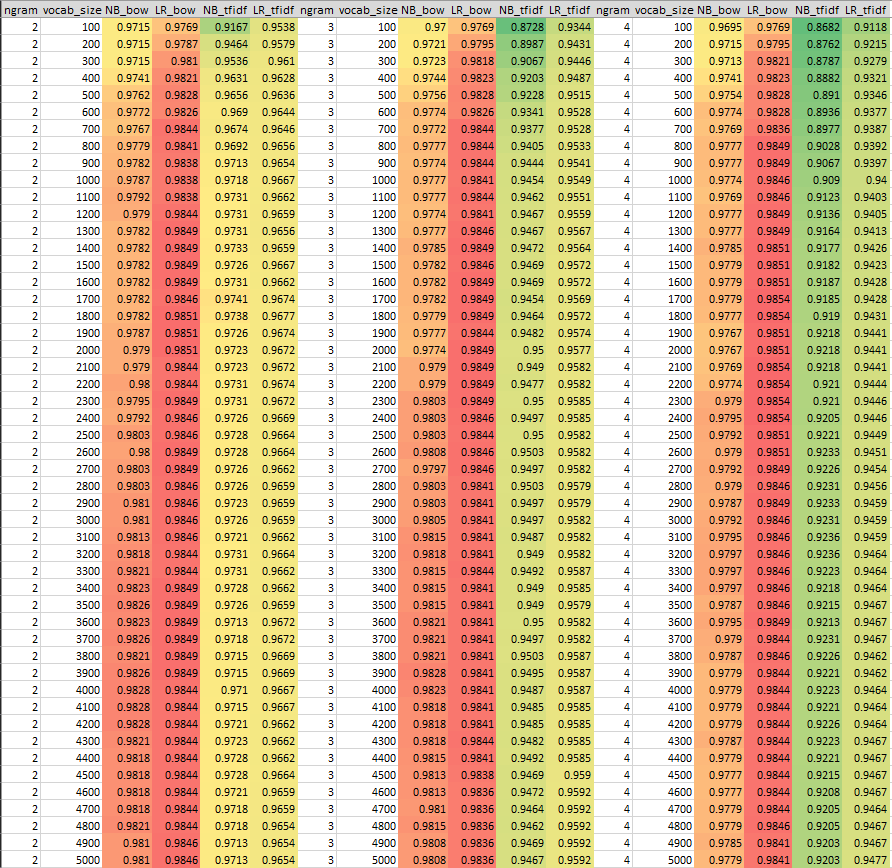

In [13]:
from IPython.display import Image
Image(os.path.join(save_dir, "Ngram_Tfidf_baseline_accuracies.PNG"))

---